<a href="https://colab.research.google.com/github/qonca/sign-language-project/blob/main/sign_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe protobuf==4.25.3 numpy==1.26.4 --no-deps --force-reinstall

  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)
  Attempting uninstall: mediapipe
    Found existing installation: mediapipe 0.10.21
    Uninstalling mediapipe-0.10.21:
      Successfully uninstalled mediapipe-0.10.21
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled nu

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"clodynov","key":"afc03877078a7d15d68ff85a11bf9814"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ayuraj/asl-dataset

Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
asl-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile

with zipfile.ZipFile('/content/asl-dataset.zip', 'r') as zip_ref:

    zip_ref.extractall()


In [5]:
import shutil

shutil.rmtree('/content/asl_dataset/asl_dataset')

In [6]:
import os

for dirpath, dirnames, filenames in os.walk('/content/asl_dataset'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 36 directories and 0 images in /content/asl_dataset
There are 0 directories and 70 images in /content/asl_dataset/1
There are 0 directories and 70 images in /content/asl_dataset/o
There are 0 directories and 70 images in /content/asl_dataset/n
There are 0 directories and 70 images in /content/asl_dataset/0
There are 0 directories and 70 images in /content/asl_dataset/k
There are 0 directories and 70 images in /content/asl_dataset/h
There are 0 directories and 70 images in /content/asl_dataset/2
There are 0 directories and 70 images in /content/asl_dataset/d
There are 0 directories and 70 images in /content/asl_dataset/j
There are 0 directories and 70 images in /content/asl_dataset/l
There are 0 directories and 70 images in /content/asl_dataset/u
There are 0 directories and 70 images in /content/asl_dataset/6
There are 0 directories and 70 images in /content/asl_dataset/g
There are 0 directories and 70 images in /content/asl_dataset/w
There are 0 directories and 70 images in /

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
data_path = '/content/asl_dataset'

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = 'training',
    seed = 42,
    image_size = IMG_SIZE,
    crop_to_aspect_ratio = True
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = 'validation',
    seed = 42,
    image_size = IMG_SIZE,
    crop_to_aspect_ratio = True
)

Found 2515 files belonging to 36 classes.
Using 2012 files for training.
Found 2515 files belonging to 36 classes.
Using 503 files for validation.


In [8]:
class_names = train_data.class_names
class_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [9]:
train_data = train_data.shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

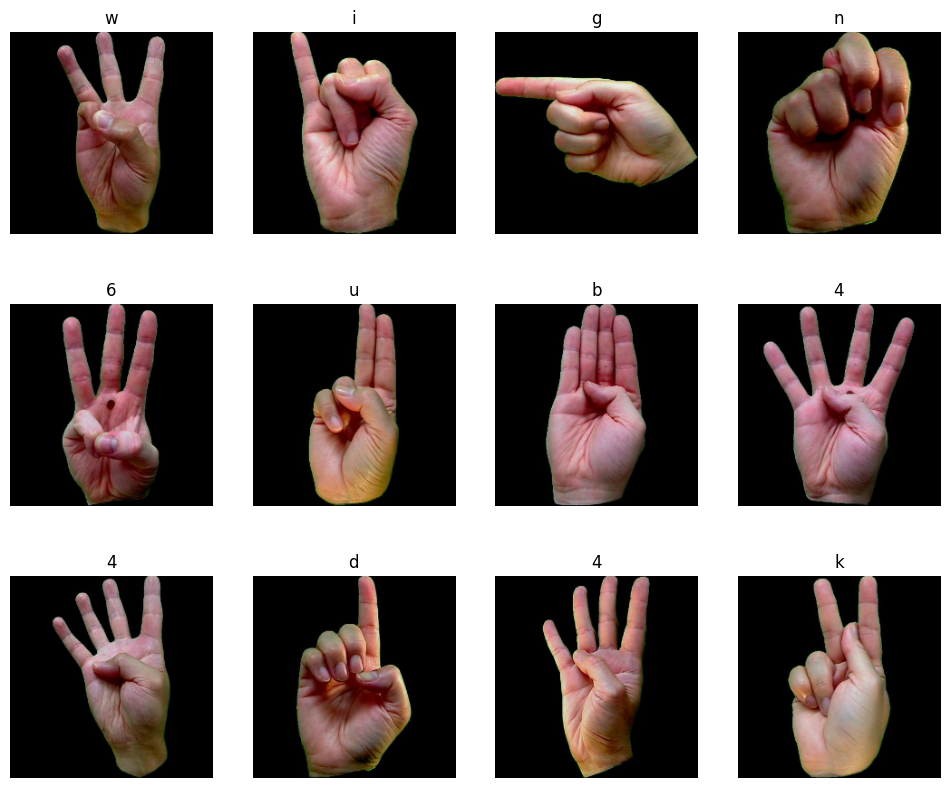

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (12,10))
for images, labels in train_data.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(images[i]/255)
        plt.title(class_names[labels[i].numpy()])
        plt.axis('off')


In [11]:
import mediapipe as mp
import cv2

In [1]:
class HandTracking:
    def __init__(self, mode = False, maxHands = 1, detectionCon=0.5, trackCon=0.5 ):
        self.__mode__ = mode
        self.__maxHands__ = maxHands
        self.__detectionCon__ = detectionCon
        self.__trackCon__ = trackCon

        self.handsMp = mp.solutions.hands
        self.hands = self.handsMp.Hands()
        self.mpDraw = mp.solutions.drawing_utils

    def findfingers(self, frame, draw = True):
        imgRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(imgRGB)
        if self.results.multi_hand_landmarks:
            for handLms in self.results.multi_hand_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(frame, handLms, self.handsMp.HAND_CONNECTIONS)

        return frame
    def findposition(self, frame, handNo = 0, draw = True):
        xList = []
        yList = []
        zList = []
        box = []
        self.lmsList = []
        if self.results.multi_hand_landmarks:
            myHand = self.results.multi_hand_landmarks[handNo]
            for id, lm in enumerate(myHand.landmark):
                h,w,c = frame.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                cz = lm.z
                xList.append(cx)
                yList.append(cy)
                zList.append(cz)
                self.lmsList.append([id, cx, cy, cz])
                if draw:
                    continue

            xmin, xmax = min(xList), max(xList)
            ymin, ymax = min(yList), max(yList)
            box = xmin, ymin, xmax, ymax
            h,w,_ = frame.shape
            xmin_box = max(0, xmin - 20)
            xmax_box = min(w, xmax + 20)
            ymin_box = max(0, ymin - 20)
            ymax_box = min(h, ymax + 20)
            if draw:
                cv2.rectangle(frame,(xmin_box, ymin_box),(xmax_box, ymax_box), (0,255,0),2)
        return self.lmsList, box

In [77]:
detector = HandTracking()



In [78]:
landmarks = []
labels_1 = []
images_1 = []
box_list = []


for images, labels in train_data:
    for i in range(len(images)):
        image = images[i].numpy().astype('uint8')
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image_bgr = detector.findfingers(image_bgr)
        lmList, box_1 = detector.findposition(image_bgr)

        if lmList is not None and len(lmList)==21:

            landmarks.append(lmList)
            labels_1.append(class_names[labels[i].numpy()])
            images_1.append(image)
            box_list.append(box_1)





In [79]:
y_train_full =[]
for i in labels_1:
    y_train_full.append(class_names.index(i))

In [80]:
y_train_full[:10]

[34, 32, 31, 23, 28, 12, 9, 20, 18, 30]

In [81]:
y_train_full = np.array(y_train_full)

In [82]:
labels_1[1]

'w'

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
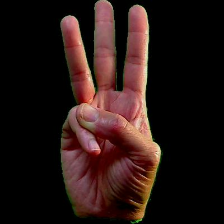

In [83]:
images_1[1]

In [84]:
box_list[1]

(63, 18, 146, 195)

In [85]:
x_test = []
y_test = []
images_test = []
box_t_list = []

for images_t, labels_t in test_data:
    for i in range(len(images_t)):
        image_t = images_t[i].numpy().astype('uint8')
        image_bgr_t = cv2.cvtColor(image_t, cv2.COLOR_RGB2BGR)
        image_bgr_t = detector.findfingers(image_bgr_t)
        lmList_t, box_t = detector.findposition(image_bgr_t)

        if lmList_t is not None and len(lmList_t)==21:

            x_test.append(lmList_t)
            y_test.append(class_names[labels_t[i].numpy()])
            images_test.append(image_bgr_t)
            box_t_list.append(box_t)



In [86]:
box_t

(65, 11, 153, 207)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
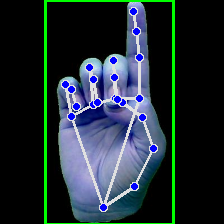

In [87]:
image_bgr_t

In [92]:
y_test[24]

'0'

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
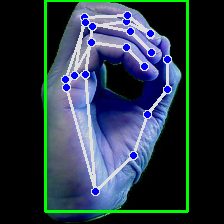

In [93]:
images_test[24]

In [94]:
#defining global angle acc to the middle finger base
import math
def global_angle(landmarks):
    angles = []
    for hand in landmarks:
        wrist_x, wrist_y = hand[0][1], hand[0][2]
        middle_base_x, middle_base_y = hand[9][1], hand[9][2]
        dx = middle_base_x - wrist_x
        dy = middle_base_y - wrist_y
        angle = math.atan2(dy,dx)
        angle_normalized = angle/math.pi
        angles.append(angle_normalized)
    return angles

In [96]:
#normalization according to the wrist

def normalize_landmarks(landmarks,box):
    normalized = []
    for hand,box in zip(landmarks,box):
        normalized_hand = []
        xmin,ymin,xmax,ymax = box
        width = xmax - xmin if xmax - xmin != 0 else 1
        height = ymax - ymin if ymax - ymin != 0 else 1
        for lms in hand:
            lms_x = lms[1] - xmin
            lms_y = lms[2] - ymin
            lms_z = lms[3]

            normalized_hand.append((lms_x/(width),lms_y/(height), lms_z))


        normalized.append(normalized_hand)


    return normalized


In [97]:
global_angles = global_angle(landmarks)

In [99]:
normalized_lms = normalize_landmarks(landmarks,box_list)

In [100]:
landmarks[1]

[[0, 134, 195, 1.97270355783985e-06],
 [1, 146, 178, -0.11856038123369217],
 [2, 143, 149, -0.1759978085756302],
 [3, 122, 127, -0.22045952081680298],
 [4, 99, 116, -0.2565237581729889],
 [5, 121, 108, -0.10844171792268753],
 [6, 122, 62, -0.18230211734771729],
 [7, 124, 39, -0.23348622024059296],
 [8, 122, 21, -0.26584190130233765],
 [9, 97, 115, -0.08955853432416916],
 [10, 84, 70, -0.1696501523256302],
 [11, 79, 41, -0.21704113483428955],
 [12, 76, 18, -0.24279117584228516],
 [13, 80, 131, -0.08334873616695404],
 [14, 73, 107, -0.18010175228118896],
 [15, 89, 124, -0.20133547484874725],
 [16, 100, 139, -0.19411437213420868],
 [17, 67, 151, -0.08612794429063797],
 [18, 63, 131, -0.15969310700893402],
 [19, 74, 139, -0.16722235083580017],
 [20, 84, 151, -0.16004355251789093]]

In [101]:
normalized_lms[1]

[(0.8554216867469879, 1.0, 1.97270355783985e-06),
 (1.0, 0.903954802259887, -0.11856038123369217),
 (0.963855421686747, 0.7401129943502824, -0.1759978085756302),
 (0.7108433734939759, 0.615819209039548, -0.22045952081680298),
 (0.43373493975903615, 0.5536723163841808, -0.2565237581729889),
 (0.6987951807228916, 0.5084745762711864, -0.10844171792268753),
 (0.7108433734939759, 0.24858757062146894, -0.18230211734771729),
 (0.7349397590361446, 0.11864406779661017, -0.23348622024059296),
 (0.7108433734939759, 0.01694915254237288, -0.26584190130233765),
 (0.40963855421686746, 0.5480225988700564, -0.08955853432416916),
 (0.25301204819277107, 0.2937853107344633, -0.1696501523256302),
 (0.1927710843373494, 0.12994350282485875, -0.21704113483428955),
 (0.1566265060240964, 0.0, -0.24279117584228516),
 (0.20481927710843373, 0.6384180790960452, -0.08334873616695404),
 (0.12048192771084337, 0.5028248587570622, -0.18010175228118896),
 (0.3132530120481928, 0.5988700564971752, -0.20133547484874725),
 (

In [102]:
global_angles[:10]

[-0.8581683444970387,
 -0.6378918963082727,
 -0.4689597557544203,
 -0.6039921609926657,
 -0.46611077799821304,
 -0.5223009760856169,
 -0.3988935274830811,
 -0.5090920946756484,
 -0.4622149176445468,
 -0.5257525745939036]

In [103]:
import numpy as np

In [104]:
global_angles_np = np.array(global_angles)

In [105]:
lm2 = np.array(normalized_lms)

In [106]:
lm2[1]

array([[ 8.55421687e-01,  1.00000000e+00,  1.97270356e-06],
       [ 1.00000000e+00,  9.03954802e-01, -1.18560381e-01],
       [ 9.63855422e-01,  7.40112994e-01, -1.75997809e-01],
       [ 7.10843373e-01,  6.15819209e-01, -2.20459521e-01],
       [ 4.33734940e-01,  5.53672316e-01, -2.56523758e-01],
       [ 6.98795181e-01,  5.08474576e-01, -1.08441718e-01],
       [ 7.10843373e-01,  2.48587571e-01, -1.82302117e-01],
       [ 7.34939759e-01,  1.18644068e-01, -2.33486220e-01],
       [ 7.10843373e-01,  1.69491525e-02, -2.65841901e-01],
       [ 4.09638554e-01,  5.48022599e-01, -8.95585343e-02],
       [ 2.53012048e-01,  2.93785311e-01, -1.69650152e-01],
       [ 1.92771084e-01,  1.29943503e-01, -2.17041135e-01],
       [ 1.56626506e-01,  0.00000000e+00, -2.42791176e-01],
       [ 2.04819277e-01,  6.38418079e-01, -8.33487362e-02],
       [ 1.20481928e-01,  5.02824859e-01, -1.80101752e-01],
       [ 3.13253012e-01,  5.98870056e-01, -2.01335475e-01],
       [ 4.45783133e-01,  6.83615819e-01

In [107]:
lm2.shape

(2000, 21, 3)

In [108]:
lm2

array([[[ 1.00000000e+00,  8.01282051e-01,  8.22423090e-07],
        [ 7.72357724e-01,  1.00000000e+00, -1.28054067e-01],
        [ 5.36585366e-01,  9.29487179e-01, -2.03494146e-01],
        ...,
        [ 3.90243902e-01,  2.62820513e-01, -3.05601835e-01],
        [ 3.82113821e-01,  3.14102564e-01, -3.03349048e-01],
        [ 3.82113821e-01,  3.71794872e-01, -2.80510694e-01]],

       [[ 8.55421687e-01,  1.00000000e+00,  1.97270356e-06],
        [ 1.00000000e+00,  9.03954802e-01, -1.18560381e-01],
        [ 9.63855422e-01,  7.40112994e-01, -1.75997809e-01],
        ...,
        [ 0.00000000e+00,  6.38418079e-01, -1.59693107e-01],
        [ 1.32530120e-01,  6.83615819e-01, -1.67222351e-01],
        [ 2.53012048e-01,  7.51412429e-01, -1.60043553e-01]],

       [[ 3.62500000e-01,  1.00000000e+00,  1.38028372e-06],
        [ 6.62500000e-01,  8.51428571e-01, -7.66716525e-02],
        [ 7.62500000e-01,  6.62857143e-01, -9.69842970e-02],
        ...,
        [ 0.00000000e+00,  3.77142857e-01,

In [109]:
x,y,z = lm2.shape

In [110]:
lm3 = lm2.reshape(x,y*z)

In [111]:
lm3.shape

(2000, 63)

In [112]:
X = np.concatenate((lm3, global_angles_np.reshape(-1,1)), axis = 1)

In [113]:
X[1]

array([ 8.55421687e-01,  1.00000000e+00,  1.97270356e-06,  1.00000000e+00,
        9.03954802e-01, -1.18560381e-01,  9.63855422e-01,  7.40112994e-01,
       -1.75997809e-01,  7.10843373e-01,  6.15819209e-01, -2.20459521e-01,
        4.33734940e-01,  5.53672316e-01, -2.56523758e-01,  6.98795181e-01,
        5.08474576e-01, -1.08441718e-01,  7.10843373e-01,  2.48587571e-01,
       -1.82302117e-01,  7.34939759e-01,  1.18644068e-01, -2.33486220e-01,
        7.10843373e-01,  1.69491525e-02, -2.65841901e-01,  4.09638554e-01,
        5.48022599e-01, -8.95585343e-02,  2.53012048e-01,  2.93785311e-01,
       -1.69650152e-01,  1.92771084e-01,  1.29943503e-01, -2.17041135e-01,
        1.56626506e-01,  0.00000000e+00, -2.42791176e-01,  2.04819277e-01,
        6.38418079e-01, -8.33487362e-02,  1.20481928e-01,  5.02824859e-01,
       -1.80101752e-01,  3.13253012e-01,  5.98870056e-01, -2.01335475e-01,
        4.45783133e-01,  6.83615819e-01, -1.94114372e-01,  4.81927711e-02,
        7.51412429e-01, -

In [114]:
x_test_normalized = normalize_landmarks(x_test,box_t_list)

In [115]:
x_test_np = np.array(x_test_normalized)

In [116]:
test_angles = np.array(global_angle(x_test))

In [117]:
y_test_idx = []

for i in y_test:
    y_test_idx.append(class_names.index(i))

In [118]:
y_test_np =np.array(y_test_idx)#test y data

In [119]:
x,y,z = x_test_np.shape

In [120]:
x_test_np = x_test_np.reshape(x,y*z)

In [121]:
x_test_np.shape

(500, 63)

In [122]:
X_test = np.concatenate((x_test_np, test_angles.reshape(-1,1)), axis = 1)#test x data

In [123]:
X_test[1]

array([ 3.18681319e-01,  1.00000000e+00, -1.48163846e-08,  7.03296703e-01,
        8.70192308e-01, -5.92965372e-02,  9.23076923e-01,  6.63461538e-01,
       -8.11686888e-02,  1.00000000e+00,  4.85576923e-01, -1.08868755e-01,
        7.58241758e-01,  4.08653846e-01, -1.30318090e-01,  6.04395604e-01,
        4.80769231e-01,  2.52506379e-02,  6.26373626e-01,  3.22115385e-01,
       -6.01070002e-02,  6.37362637e-01,  3.84615385e-01, -1.44171089e-01,
        6.15384615e-01,  4.75961538e-01, -1.86309934e-01,  3.84615385e-01,
        4.61538462e-01,  1.72160435e-02,  4.06593407e-01,  2.40384615e-01,
       -1.14867594e-02,  4.17582418e-01,  1.15384615e-01, -5.11142984e-02,
        4.28571429e-01,  0.00000000e+00, -8.27424079e-02,  1.97802198e-01,
        4.90384615e-01, -1.31237656e-02,  2.08791209e-01,  2.83653846e-01,
       -4.39113043e-02,  2.08791209e-01,  1.58653846e-01, -6.75903335e-02,
        2.08791209e-01,  4.80769231e-02, -8.40990767e-02,  0.00000000e+00,
        5.52884615e-01, -

In [124]:
X_test.shape

(500, 64)

In [125]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

In [126]:
from tensorflow.keras import regularizers

In [127]:
x_valid = X[:700]
y_valid = y_train_full[:700]

In [128]:
X_train = X[700:]
y_train = y_train_full[700:]

In [129]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = X.shape[1:]),
    tf.keras.layers.Dense(256,kernel_regularizer=regularizers.l2(0.0001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Dense(128,kernel_regularizer=regularizers.l2(0.0001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Dense(64,kernel_regularizer=regularizers.l2(0.0001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.Dense(32,kernel_regularizer=regularizers.l2(0.0001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.Dense(16,kernel_regularizer=regularizers.l2(0.0001), activation = 'relu'),
    tf.keras.layers.Dense(36, activation = 'softmax')

])


In [130]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True)

In [131]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('mymodel.keras',
                                                      save_weights_only = False,
                                                      save_freq = 'epoch',
                                                      save_best_only = True

)

In [132]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2,
                                                 patience = 5, min_lr = 0.0001)

In [133]:
optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer = optimizer,
    metrics = ['accuracy'],
    loss = 'sparse_categorical_crossentropy'

)

In [134]:
history = model.fit(X_train, y_train, epochs = 200,
          validation_data = (x_valid, y_valid),
          callbacks = [model_checkpoint,reduce_lr])

Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0483 - loss: 3.7178 - val_accuracy: 0.0557 - val_loss: 3.5971 - learning_rate: 0.0010
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1681 - loss: 3.2228 - val_accuracy: 0.0757 - val_loss: 3.5453 - learning_rate: 0.0010
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2579 - loss: 2.8548 - val_accuracy: 0.1143 - val_loss: 3.4174 - learning_rate: 0.0010
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3677 - loss: 2.5376 - val_accuracy: 0.1471 - val_loss: 3.2099 - learning_rate: 0.0010
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4183 - loss: 2.2564 - val_accuracy: 0.1414 - val_loss: 3.0217 - learning_rate: 0.0010
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4693 - loss: 2.0065 - val_accuracy: 0.2686 - val_loss: 2.6683 - learning_rate: 0.0010
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5549 - loss: 1.7221 - val

<Axes: >

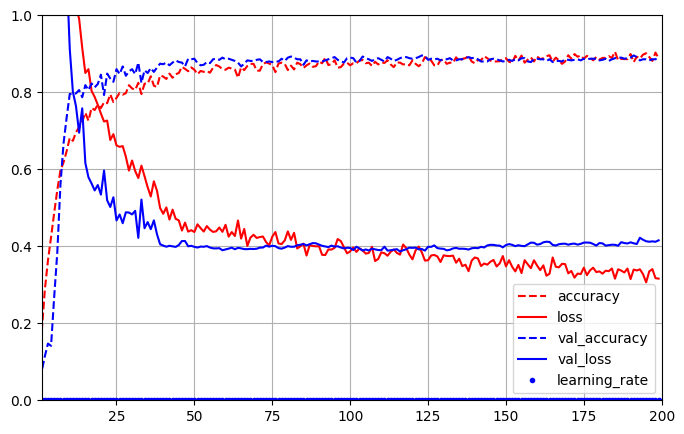

In [135]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5), xlim=[1,200], ylim =[0,1],
                                   grid = True, style = ['r--', 'r-', 'b--','b-','b.'], label = True)

In [136]:
model.evaluate(X_test, y_test_np)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9057 - loss: 0.4095 


[0.4037672281265259, 0.9039999842643738]

In [137]:
preds = model.predict(X_test)
pred_classes = preds.argmax(axis=1)
print("Predictions:", pred_classes[:20])
print("True labels:", y_test_np[:20])


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions: [35 15 14 10  8 23  1 17 13  3 33 34 20 32 18 34  0 16  3  9]
True labels: [35 15 14 10  8 23  1 17 13  3 33 34 20 32 18 34  0 16  3  9]


In [138]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



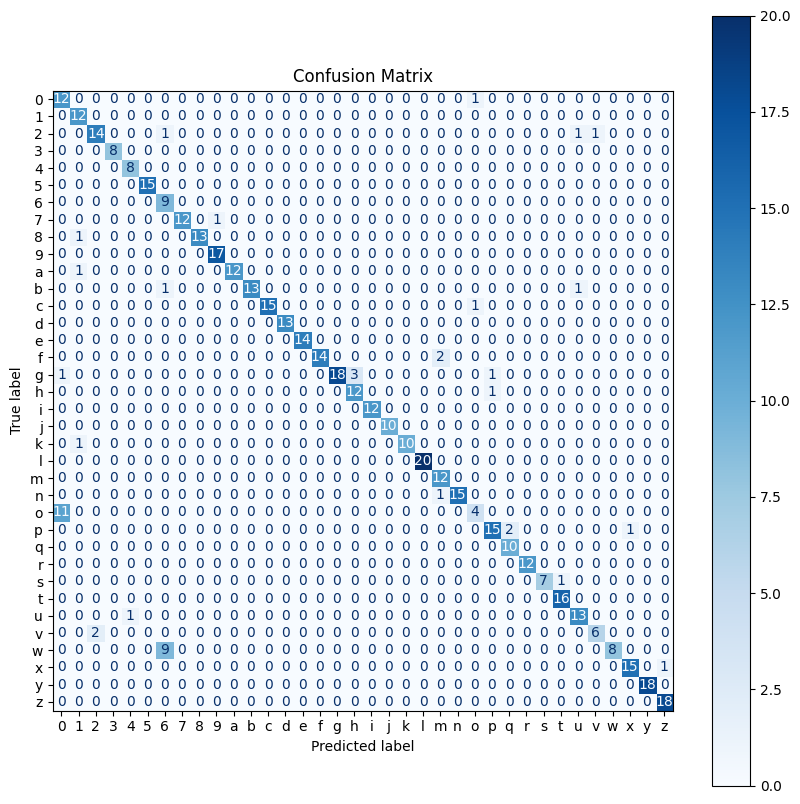

In [139]:
cm = confusion_matrix(y_test_np, pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [155]:
model.save('my_model.keras')

In [140]:
import os

In [141]:
folder_path = '/content/drive/MyDrive/signs'

In [142]:
for file in os.listdir(folder_path):
    print(file)

.DS_Store
l.jpg
6.jpg
y.jpg
j.jpg
b.jpg
c.jpg
2.jpg
n.jpg
o.jpg
i.jpg
a.jpg
m.jpg
7.jpg
5.jpg
3.jpg


In [144]:
images_1 = []
names = []
for file in os.listdir(folder_path):
    if file.endswith('.jpg'):
        img_path = os.path.join(folder_path, file)
        img_1 = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        images_1.append(img_rgb)
        names.append(file)

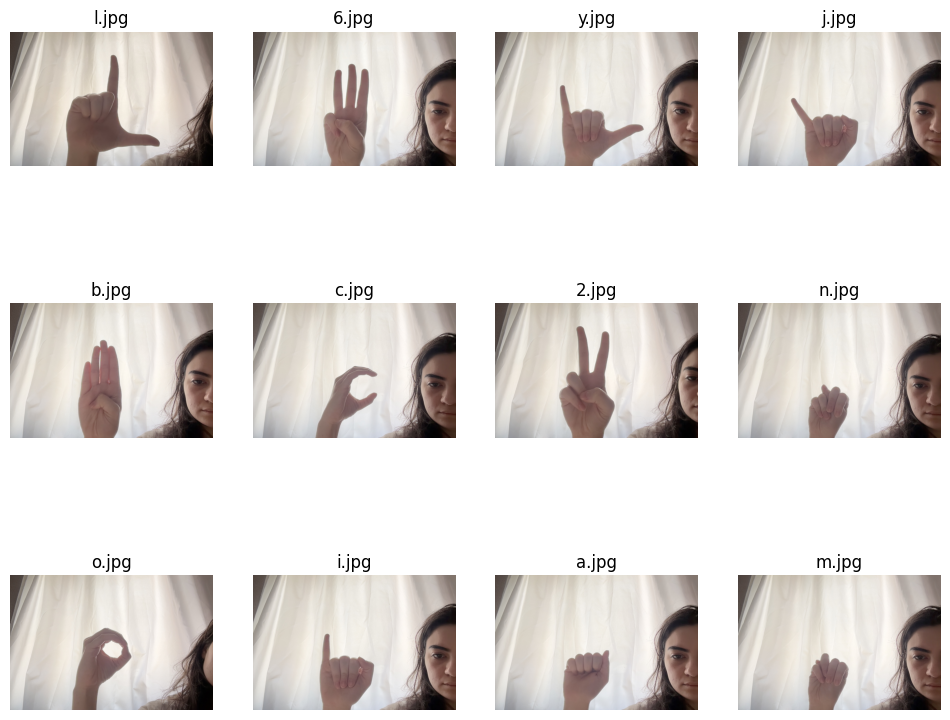

In [145]:
plt.figure(figsize = (12,10))
for i, img in enumerate(images_1[:12]):
    plt.subplot(3,4,i+1)
    plt.imshow(img/255)
    plt.title(names[i])
    plt.axis('off')

In [147]:
lndmrks = []
imgs_processed = []
box_mine = []
for img in images_1:
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_f = detector.findfingers(img)
    lms, my_box = detector.findposition(img_f)
    if lms is not None and len(lms)==21:
        lndmrks.append(lms)
        imgs_processed.append(img_f)
        box_mine.append(my_box)


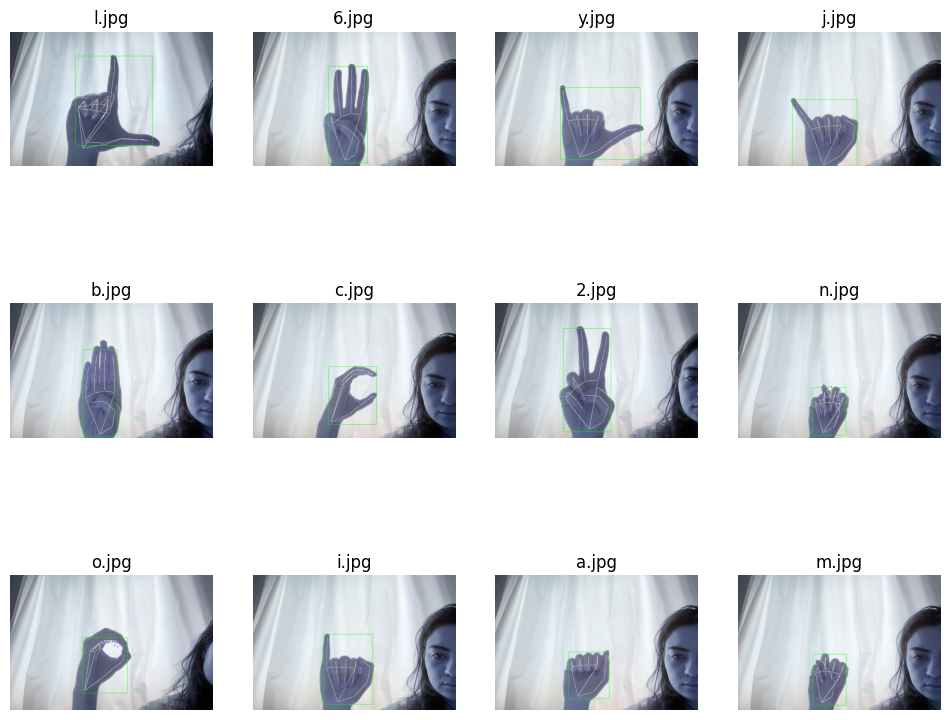

In [148]:
plt.figure(figsize = (12,10))
for i,img_f in enumerate(imgs_processed[:12]):
    plt.subplot(3,4,i+1)
    plt.imshow(img_f)
    plt.title(names[i])
    plt.axis('off')

In [149]:
angles_me = np.array(global_angle(lndmrks))

In [150]:
lndmrks_normalized = np.array(normalize_landmarks(lndmrks,box_mine))

In [151]:
new_landmarks = lndmrks_normalized.reshape(-1,21*3)

In [152]:
X_me = np.concatenate((new_landmarks,angles_me.reshape(-1,1)), axis = 1)

In [153]:
y_me = names

In [154]:
preds_me = model.predict(X_me)
pred_classes_me = preds_me.argmax(axis = 1)
print('predicted classes: ',pred_classes_me[:10])
print('actual classes: ',y_me[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
predicted classes:  [21  6 34 18 11 12 31 30 12 34]
actual classes:  ['l.jpg', '6.jpg', 'y.jpg', 'j.jpg', 'b.jpg', 'c.jpg', '2.jpg', 'n.jpg', 'o.jpg', 'i.jpg']
